# Feature Enginering 

The previous sections outline the fundamental ideas of machine learning, but all fo the exmaples assume that you have numerical data in a tidy, `[n_samples, n_features]` format. In the real world, data rarely comes in such a form. With this in mind, one of the more important steps in using machine learning in practice is *feature engineering*: that is, taking whatever information you have about your problem and turning it into numbers that you can use to build your feature matrix.

In this section, we will cover a few common examples of feature engineering tasks:

features  for representing *categorical data*, features for representing *text*, and *features* for representing *images*. Additionally, we will discuss *derived features* for increasing model complexity and *imputation* of missin data. Often this process is known as *vectorization*, as it involves converting arbitratry data into well-behaved vectors.

## Categorical Features 

One common type of non-numerical data is *categorical* data. For example, imagine you are exploring some data on housing prices, and along with numerical features like "price" and "rooms", you also have "neighborhood" information. For example, your data might look something like this:

In [1]:
data = [
    {'price': 850000, 'rooms': 4, 'neighborhood': 'Queen Anne'},
    {'price': 700000, 'rooms': 3, 'neighborhood': 'Fremont'},
    {'price': 650000, 'rooms': 3, 'neighborhood': 'Wallingford'},
    {'price': 600000, 'rooms': 2, 'neighborhood': 'Fremont'}
]

You might be tempted to encode this data with a straightforward numerical mapping:

In [2]:
{'Queen Anne': 1, 'Fremont': 2, 'Wallingford': 3}

{'Queen Anne': 1, 'Fremont': 2, 'Wallingford': 3}

It turns out that his is not generally a useful approach in Scikit-Learn: the package's models make the fundamental assumption that numerical features reflect algebraic quantities. Thus such a mapping would imply, for example, that *Queen Anne < Fremont < Wallingford* or even that *Wallingford - Queen Anne* = *Fremont*, which (niche demographic jokes aside) does not make such sense.

In this case, one proven technique is to use *one-hot encoding*, which effectively creates extra columns indicating the presence or absence of a category with a value or 1 or 0, respectively. When your data comes as list of dictionaries, Scikit-Learn's `DictVectorizer` will do this for you:

In [3]:
from sklearn.feature_extraction import DictVectorizer
vec = DictVectorizer(sparse=False, dtype=int)
vec.fit_transform(data)

array([[     0,      1,      0, 850000,      4],
       [     1,      0,      0, 700000,      3],
       [     0,      0,      1, 650000,      3],
       [     1,      0,      0, 600000,      2]])

Notice that the 'neighborhood' column has been expanded into three separate columns, representing the three neighborhod labels, and that each row has a 1 in the column associated with its neighborhood. With these categorical features thus encodes, you can proceed as normal with fitting a Scikit-Learn model.

To see the meaning of each column, you can inspect the feature names:

In [4]:
vec.get_feature_names()

['neighborhood=Fremont',
 'neighborhood=Queen Anne',
 'neighborhood=Wallingford',
 'price',
 'rooms']

There is one clear disadvantage of this approach: if your category has many possible values, this can *greatly* increase the size of your dataset. However, because the encodes data contains mostly zeros, a sparse output can be a very efficient solution:

In [6]:
vec = DictVectorizer(sparse=True, dtype=int)
vec.fit_transform(data)

<4x5 sparse matrix of type '<class 'numpy.int32'>'
	with 12 stored elements in Compressed Sparse Row format>

Many (though not yer all) of the Scikit-Learn estimators accept such sparse inputs when fitting and evaluating models. `sklearn.preprocessing.OneHotEncoder` and `sklearn.feature-extraction.FeatureHasher` are two additional tools taht Scikiti-Learn includes to support this type of encoding.

## Text Features

Another common need in feature engineering is to convert text to a set of representative numerical values. For example, most automatic mining of social media data relies on some form of encoding the text as numbers. One of the simplest methods of encoding data is by *woed counts*: you take each snippet of text, count the ocurrences of each word within it, and put the results in a table.

For example, consider the foloowing set of three phrases:

In [7]:
sample = ['problem of evil', 'evil queen', 'horizon problem']

For a vectorization of this dta based on word count, we could construct a column representing the word "problem", the word "evil," the word "horizon", and so on. While doing this by hand would be possible, the tedium can be avoided byusing Scikit-Learn's `CountVectorizer`:

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer()
X = vec.fit_transform(sample)
X

<3x5 sparse matrix of type '<class 'numpy.int64'>'
	with 7 stored elements in Compressed Sparse Row format>

In [10]:
import pandas as pd 

pd.DataFrame(X.toarray(), columns=vec.get_feature_names())

,evil,horizon,of,problem,queen
0,1,0,1,1,0
1,1,0,0,0,1
2,0,1,0,1,0


There are some issues with this approach, however: the raw word counts lead to features which put too much weight on words that appear very frequently, and this ca be sub-optimal in some classification algorithms. One approach to fix this is known as *term frequency-inverse document frequency (TF-IDF)* which weights the word counts by a measure of how often they appear in the documents. The syntax for computing these features is similar to the previous example:

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer 
vec = TfidfVectorizer()
X = vec.fit_transform(sample)
pd.DataFrame(X.toarray(), columns=vec.get_feature_names())

,evil,horizon,of,problem,queen
0,0.517856,0.000000,0.680919,0.517856,0.000000
1,0.605349,0.000000,0.000000,0.000000,0.795961
2,0.000000,0.795961,0.000000,0.605349,0.000000


## Image Features 

Another common need is to suitable encode *images* for machine learning analysis. The simplest approach is what we used for the digits data in the introduction, simply using the pixel values themselves. But depending on the application, such approaches may not be optimal.

A comprehensive sumamry of these features extraction techniques for images is well beyonc the scope of this section.

## Derived Features

Another useful type of feature is one that is mathematically derived from some input features. An example of this is when we constructed *polynomial features* from our input data. We saw that we could convert alienar regresion into a polynomial regression not by changin the model, but by transforming the input! This is sometimes known as *basis function regression*.

For example, this data clearl y cannot be described by a straight line:

In [14]:
%matplotlib inline 
import numpy as np 
import matplotlib.pyplot as plt

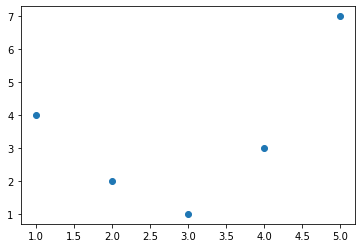

In [18]:
x = np.array([1, 2, 3, 4, 5])
y = np.array([4, 2, 1, 3, 7])
plt.scatter(x, y);

Still, we can fit a line to the data using `LinearRegression` and get the optimal result:

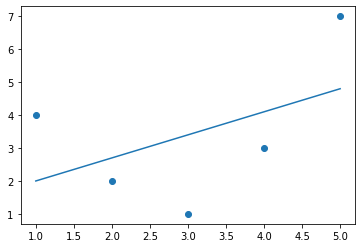

In [21]:
from sklearn.linear_model import LinearRegression

X = x[:, np.newaxis]
model = LinearRegression().fit(X, y)
yfit = model.predict(X)
plt.scatter(x, y)
plt.plot(x, yfit);

It's clear that we need a more sophisticated model to describe the relationship between *x* and *y*

One approach to this is to transform the data, adding extra columns of features to drive more flexibility in the model. For example, we can add polynomial features to the data this way:

In [24]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=3, include_bias=False)
X2 = poly.fit_transform(X)
print(X2)

[[  1.   1.   1.]
 [  2.   4.   8.]
 [  3.   9.  27.]
 [  4.  16.  64.]
 [  5.  25. 125.]]


The derived feature matrix has one column represeting *x*, and a second column representing $x^2$, and a third column representing $x^3$. Computing a linear regression on this expanded input gives a much loser fit to our data:

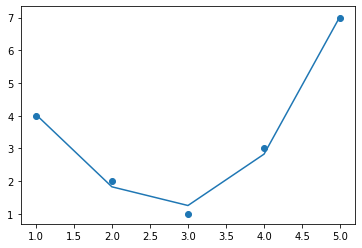

In [26]:
model = LinearRegression().fit(X2, y)
yfit = model.predict(X2)
plt.scatter(x, y)
plt.plot(x, yfit);

This idea of imporivng a model not by changing the model, but by transforming the inputs, is fundamental to many of the more powerful machine learning methods. We explore this idea further, in the context of *basis function regression*. More generally, this is one motivational path to the powerful set of techniques known as *kernel methods*.

## Imputation of Missing Data
Another common need in feature engineering is handling of missing data. We discussed the handling of missing data in `DataFrame` and saw that often the `NaN` value is used to mark missing values. For example, we might have a dataset that looks like this:

In [29]:
from numpy import nan 

X = np.array([[nan, 0, 3],
              [3, 7, 9],
              [3, 5, 2],
              [4, nan, 6],
              [8, 8, 1]
              ])
              
y = np.array([14, 16, -1, 8, -5])              

We applying a typical machine learning model to such data, we will nned to first replace such missing data with some appropriate fill value. This is known as *imputation* of missing values, and strategies range from simple(e.g., replacing missing values with the mean of the column) to sophisticated(e.g, using matrix completio nor a robust model to handle such data).

The sophisticated approaches tend to be very application-specific, and we won't dive into them here. for a baseline imputation apporach, using the mean, median, or most frequent value, Scikit-Learn provied the `Imputer` class:

In [32]:
from sklearn.impute import SimpleImputer 
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
X2 = imp.fit_transform(X)
X2

array([[4.5, 0. , 3. ],
       [3. , 7. , 9. ],
       [3. , 5. , 2. ],
       [4. , 5. , 6. ],
       [8. , 8. , 1. ]])

We see that in the resulting data, the two missing values have been repalced with the mean ofthe remainign values in the column. This imputed data can then be fed directly into, for example, a `LinearRegression` estimator:

In [33]:
model = LinearRegression().fit(X2, y)
model.predict(X2)

array([13.14869292, 14.3784627 , -1.15539732, 10.96606197, -5.33782027])